In [1]:
pip install xgboost

Note: you may need to restart the kernel to use updated packages.


In [3]:
# Import necessary libraries for data manipulation, numerical operations, and visualization
import pandas as pd
import numpy as np
import xgboost as xgb
from sklearn.metrics import mean_squared_error, mean_absolute_error
import matplotlib.pyplot as plt
from scipy import stats
import seaborn as sns
import warnings
# Suppress specific warnings that might clutter output
warnings.filterwarnings('ignore')

# --- 1. Data Loading (or Simulation) ---
# Assume your data is in DataFrame 'df'
# Let's create a simulation of data based on the provided image for example
# In a real situation, you would load from CSV, database, etc.
# Load the dataset from the specified CSV file path
df= pd.read_csv(r'C:\Users\Olga\Desktop\save in one\Sample - Superstore.csv')
df.head()
df.info()

# Convert dates to the correct format (if not in 'YYYY-MM-DD')
# Your format 'DD.MM.YYYY'
# Convert 'Order Date' and 'Ship Date' columns to datetime objects for time series analysis
# Note: pandas is usually smart enough to infer DD.MM.YYYY, but specifying format can be safer
# For 'DD.MM.YYYY', you might need: format='%d.%m.%Y' if inference fails
df['Order Date']=pd.to_datetime(df['Order Date']) # pandas usually handles this format well
df['Ship Date']=pd.to_datetime(df['Ship Date'])   # pandas usually handles this format well

# Remove rows with incorrect dates, if any appeared
df.dropna(subset=['Order Date'], inplace=True)

print("Original Data (first 5 rows):")
print(df.head())
print("\nData Information:")
df.info()

# --- 2. Data Aggregation by Time ---
# Aggregate by month, summing sales
monthly_sales = df.groupby(pd.Grouper(key='Order Date', freq='M'))['Sales'].sum().reset_index()
monthly_sales = monthly_sales.rename(columns={'Order Date': 'Month'})

# Ensure the time series is continuous and sorted
monthly_sales = monthly_sales.set_index('Month').asfreq('M').fillna(0) # Fill missing months with zeros
monthly_sales = monthly_sales.reset_index()

print("\nAggregated Monthly Sales (first 5 rows):")
print(monthly_sales.head())
print("\nAggregated Monthly Sales (last 5 rows):")
print(monthly_sales.tail())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 9994 entries, 0 to 9993
Data columns (total 21 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   Row ID         9994 non-null   int64  
 1   Order ID       9994 non-null   object 
 2   Order Date     9994 non-null   object 
 3   Ship Date      9994 non-null   object 
 4   Ship Mode      9994 non-null   object 
 5   Customer ID    9994 non-null   object 
 6   Customer Name  9994 non-null   object 
 7   Segment        9994 non-null   object 
 8   Country        9994 non-null   object 
 9   City           9994 non-null   object 
 10  State          9994 non-null   object 
 11  Postal Code    9994 non-null   int64  
 12  Region         9994 non-null   object 
 13  Product ID     9994 non-null   object 
 14  Category       9994 non-null   object 
 15  Sub-Category   9994 non-null   object 
 16  Product Name   9994 non-null   object 
 17  Sales          9994 non-null   float64
 18  Quantity

In [4]:
# --- 3. Feature Engineering ---
# Create functions for feature generation

def create_features(df_agg):
    df_agg['month'] = df_agg['Month'].dt.month
    df_agg['quarter'] = df_agg['Month'].dt.quarter
    df_agg['year'] = df_agg['Month'].dt.year
    df_agg['dayofweek'] = df_agg['Month'].dt.dayofweek # 0=Monday, 6=Sunday
    df_agg['dayofyear'] = df_agg['Month'].dt.dayofyear
    df_agg['weekofyear'] = df_agg['Month'].dt.isocalendar().week.astype(int) # Week of the year
    df_agg['month_start'] = (df_agg['Month'].dt.is_month_start).astype(int)
    df_agg['month_end'] = (df_agg['Month'].dt.is_month_end).astype(int)

    # More complex features can be added, such as holiday indicators, promotions, etc.

    return df_agg

def create_lag_features(df_agg, lags):
    df_lag = df_agg.copy()
    for lag in lags:
        df_lag[f'Sales_Lag_{lag}'] = df_lag['Sales'].shift(lag)
    return df_lag

def create_rolling_features(df_agg, windows):
    df_roll = df_agg.copy()
    for window in windows:
        # Use closed='left' so the rolling window ends BEFORE the current period
        df_roll[f'Sales_RollingMean_{window}'] = df_roll['Sales'].shift(1).rolling(window=window, closed='left').mean()
        # Other statistics can be added: sum, std, min, max, etc.
    return df_roll

# Generate time-based features
monthly_sales = create_features(monthly_sales)

# Generate lagged features
lags_to_use = [1, 2, 3, 6, 12] # Lags for 1, 2, 3, 6, and 12 months
monthly_sales = create_lag_features(monthly_sales, lags_to_use)

# Generate rolling averages
windows_to_use = [3, 6] # Rolling average for 3 and 6 months
monthly_sales = create_rolling_features(monthly_sales, windows_to_use)

# Remove rows with NaN values that appeared due to lags and rolling windows
# (the first rows for which lags/rolling features cannot be calculated)
min_lag = max(lags_to_use + windows_to_use) if lags_to_use or windows_to_use else 0
monthly_sales.dropna(inplace=True)

print("\nData with Features (first 5 rows after removing NaN):")
print(monthly_sales.head())
print("\nInformation about Data with Features:")
monthly_sales.info()


Data with Features (first 5 rows after removing NaN):
        Month       Sales  month  quarter  year  dayofweek  dayofyear  \
12 2015-01-31  18174.0756      1        1  2015          5         31   
13 2015-02-28  11951.4110      2        1  2015          5         59   
14 2015-03-31  38726.2520      3        1  2015          1         90   
15 2015-04-30  34195.2085      4        2  2015          3        120   
16 2015-05-31  30131.6865      5        2  2015          6        151   

    weekofyear  month_start  month_end  Sales_Lag_1  Sales_Lag_2  Sales_Lag_3  \
12           5            0          1   69545.6205   78628.7167   31453.3930   
13           9            0          1   18174.0756   69545.6205   78628.7167   
14          14            0          1   11951.4110   18174.0756   69545.6205   
15          18            0          1   38726.2520   11951.4110   18174.0756   
16          22            0          1   34195.2085   38726.2520   11951.4110   

    Sales_Lag_6  Sa

In [5]:
# --- 4. Splitting Data into Training and Test Sets ---
# Split by time. For example, use data up to a certain date for training
# In our example, data covers 2015-2018. Let's train up to the end of 2016, test on 2017-2018.

split_date = '2016-12-31' # Split date

train_df = monthly_sales[monthly_sales['Month'] <= split_date].copy()
test_df = monthly_sales[monthly_sales['Month'] > split_date].copy() # Forecast on data after split_date

print(f"\nTraining set size: {len(train_df)} months")
print(f"Test set size: {len(test_df)} months")

# Define features (X) and target variable (y)
features = [col for col in train_df.columns if col not in ['Month', 'Sales']]
target = 'Sales'

X_train = train_df[features]
y_train = train_df[target]

X_test = test_df[features]
y_test = test_df[target]

print(f"\nFeatures used: {features}")


Training set size: 24 months
Test set size: 12 months

Features used: ['month', 'quarter', 'year', 'dayofweek', 'dayofyear', 'weekofyear', 'month_start', 'month_end', 'Sales_Lag_1', 'Sales_Lag_2', 'Sales_Lag_3', 'Sales_Lag_6', 'Sales_Lag_12', 'Sales_RollingMean_3', 'Sales_RollingMean_6']


In [6]:
# --- 5. Training the XGBoost Model ---
# Initialize and train the XGBoost regressor
# Specify objective='reg:squarederror' for the regression task
# Use eval_set to monitor performance on the test set (during training)
# early_stopping_rounds allows stopping training earlier if performance on eval_set stops improving

print("\nStarting XGBoost training...")
model = xgb.XGBRegressor(objective='reg:squarederror',
                         n_estimators=1000,  # Number of trees
                         learning_rate=0.05, # Learning rate
                         max_depth=5,        # Maximum tree depth
                         random_state=42,
                         n_jobs=-1,          # Use all processor cores
                         # Regularization parameters, can be tuned:
                         # gamma=0,
                         # subsample=0.8,
                         # colsample_bytree=0.8,
                         # reg_alpha=0,
                         # reg_lambda=1,
                         )

# For demonstration, we use a simple fit.
# In a real time series task, it's better to use eval_set with time series cross-validation
# or at least use a portion of train_df as a validation_set
model.fit(X_train, y_train,
          # eval_set=[(X_train, y_train), (X_test, y_test)], # Can add eval_set for monitoring
          # early_stopping_rounds=50, # Stop if metric doesn't improve on eval_set
          verbose=False # Set to True to display training process
         )

print("Training completed.")


Starting XGBoost training...
Training completed.



Evaluation on the test set:
RMSE: 20434.00
MAE: 16856.03
MAPE: 28.97%
SMAPE: 33.20%


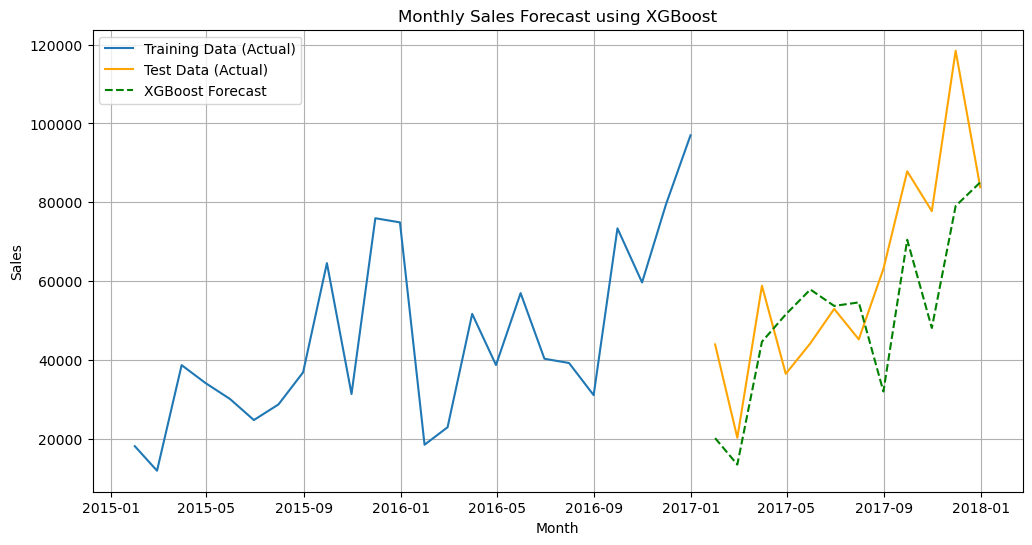


Feature Importance from XGBoost:
                Feature  Importance
12         Sales_Lag_12    0.784924
14  Sales_RollingMean_6    0.068567
4             dayofyear    0.048175
11          Sales_Lag_6    0.035485
2                  year    0.029386
0                 month    0.017178
3             dayofweek    0.006868
10          Sales_Lag_3    0.005187
13  Sales_RollingMean_3    0.002023
5            weekofyear    0.000976
8           Sales_Lag_1    0.000903
9           Sales_Lag_2    0.000327
1               quarter    0.000000
6           month_start    0.000000
7             month_end    0.000000


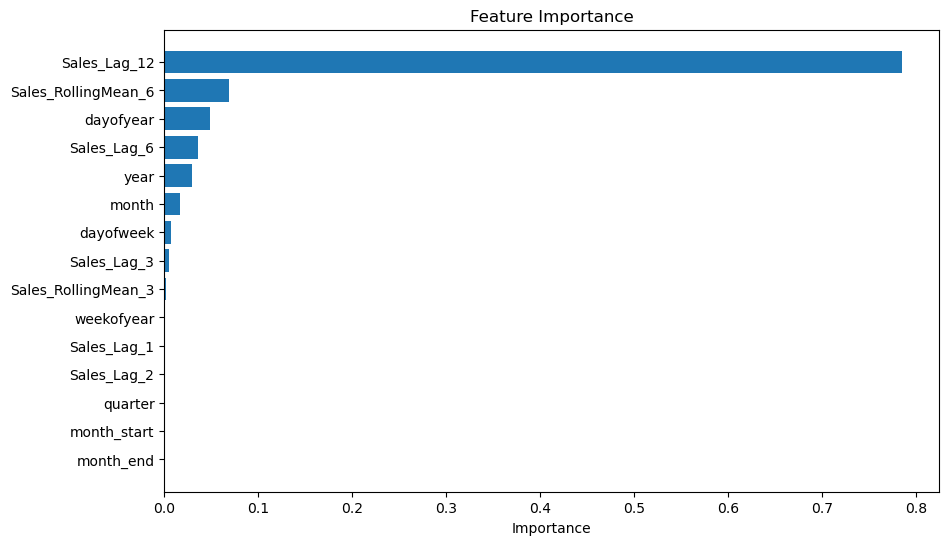

In [7]:
# --- 6. Forecasting on the Test Set ---
# For forecasting on the test set (within historical data), you can predict all at once
# For forecasting into the FUTURE (beyond test_df), a recursive forecasting loop will be required!
y_pred = model.predict(X_test)

# Ensure predictions are non-negative, as sales cannot be negative
y_pred[y_pred < 0] = 0


# --- 7. Evaluating Forecast Quality ---
rmse = np.sqrt(mean_squared_error(y_test, y_pred))
mae = mean_absolute_error(y_test, y_pred)
# MAPE can be incorrect with zero actual values
# mape = np.mean(np.abs((y_test - y_pred) / y_test)) * 100 # Original MAPE calculation
# Using a safer calculation if y_test can be zero:
mape = np.mean(np.abs((y_test - y_pred) / (y_test + 1e-8))) * 100 # Add epsilon to avoid division by zero

smape = np.mean(2 * np.abs(y_test - y_pred) / (np.abs(y_test) + np.abs(y_pred) + 1e-8)) * 100 # Symmetric MAPE, better for zeros

print(f"\nEvaluation on the test set:")
print(f"RMSE: {rmse:.2f}")
print(f"MAE: {mae:.2f}")
print(f"MAPE: {mape:.2f}%")
print(f"SMAPE: {smape:.2f}%")


# --- 8. Visualization of Results ---
plt.figure(figsize=(12, 6))
plt.plot(train_df['Month'], train_df['Sales'], label='Training Data (Actual)')
plt.plot(test_df['Month'], y_test, label='Test Data (Actual)', color='orange')
plt.plot(test_df['Month'], y_pred, label='XGBoost Forecast', color='green', linestyle='--')
plt.title('Monthly Sales Forecast using XGBoost')
plt.xlabel('Month')
plt.ylabel('Sales')
plt.legend()
plt.grid(True)
plt.show()

# --- Feature Importance Visualization ---
print("\nFeature Importance from XGBoost:")
importance = model.feature_importances_
feature_importance = pd.DataFrame({'Feature': features, 'Importance': importance}).sort_values(by='Importance', ascending=False)
print(feature_importance)

plt.figure(figsize=(10, 6))
plt.barh(feature_importance['Feature'], feature_importance['Importance'])
plt.title('Feature Importance')
plt.xlabel('Importance')
plt.gca().invert_yaxis() # Most important features at the top
plt.show()

First 5 rows of aggregated data:
            Total_Sales
Month                  
2014-01-31    14236.895
2014-02-28     4519.892
2014-03-31    55691.009
2014-04-30    28295.345
2014-05-31    23648.287

Last 5 rows of aggregated data:
            Total_Sales
Month                  
2017-08-31   63120.8880
2017-09-30   87866.6520
2017-10-31   77776.9232
2017-11-30  118447.8250
2017-12-31   83829.3188

Total 48 months of data (from 2014-01-31 to 2017-12-31)

Training set size: 36 months (up to 2016-12-31)
Test set size: 12 months (2017-01-31 - 2017-12-31)


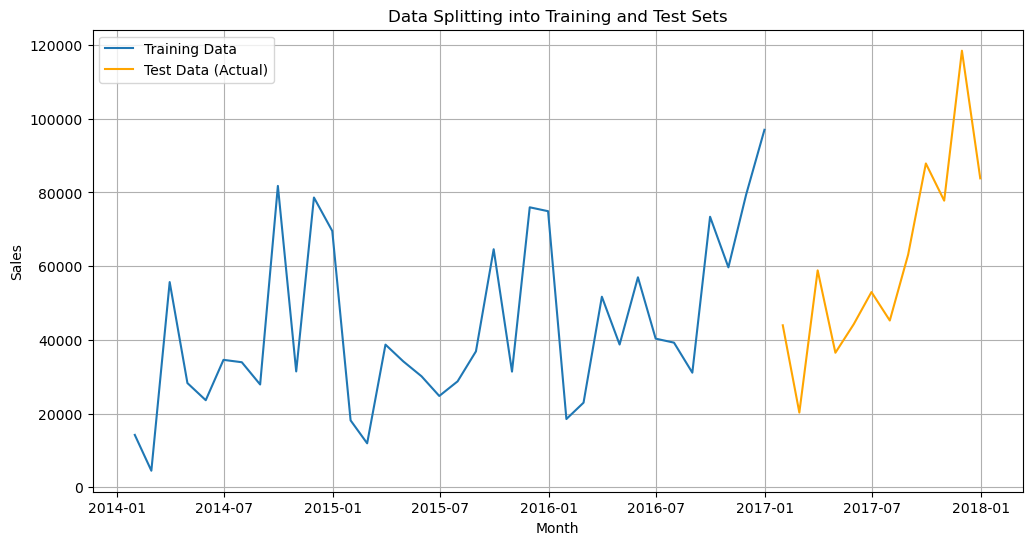


--- SARIMA Training and Evaluation ---
Performing stepwise search to minimize aic
 ARIMA(0,1,0)(0,1,0)[12]             : AIC=510.637, Time=2.74 sec
 ARIMA(1,1,0)(1,1,0)[12]             : AIC=505.811, Time=0.55 sec
 ARIMA(0,1,1)(0,1,1)[12]             : AIC=504.971, Time=0.33 sec
 ARIMA(0,1,1)(0,1,0)[12]             : AIC=510.684, Time=0.16 sec
 ARIMA(0,1,1)(1,1,1)[12]             : AIC=inf, Time=0.61 sec
 ARIMA(0,1,1)(0,1,2)[12]             : AIC=505.714, Time=1.96 sec
 ARIMA(0,1,1)(1,1,0)[12]             : AIC=506.395, Time=0.32 sec
 ARIMA(0,1,1)(1,1,2)[12]             : AIC=inf, Time=3.51 sec
 ARIMA(0,1,0)(0,1,1)[12]             : AIC=506.196, Time=0.12 sec
 ARIMA(1,1,1)(0,1,1)[12]             : AIC=inf, Time=0.90 sec
 ARIMA(0,1,2)(0,1,1)[12]             : AIC=507.330, Time=0.30 sec
 ARIMA(1,1,0)(0,1,1)[12]             : AIC=504.918, Time=0.21 sec
 ARIMA(1,1,0)(0,1,0)[12]             : AIC=507.714, Time=0.10 sec
 ARIMA(1,1,0)(1,1,1)[12]             : AIC=506.244, Time=0.33 sec
 ARIM

16:39:38 - cmdstanpy - INFO - Chain [1] start processing
16:39:42 - cmdstanpy - INFO - Chain [1] done processing


Prophet metrics on the test set: {'RMSE': 18608.84386413422, 'MAE': 14120.6748511595, 'MAPE': 23.360653343317253, 'SMAPE': 30.623445496493368}

--- XGBoost Training and Evaluation ---
XGBoost uses 12 features.
Example features: ['month', 'quarter', 'year', 'month_year', 'Sales_Lag_1'] ...
XGBoost training set contains data from 2015-02-28 to 2016-12-31

Starting recursive XGBoost forecast...
XGBoost metrics on the test set: {'RMSE': 22291.513631093716, 'MAE': 15284.906386458335, 'MAPE': 39.84651434467133, 'SMAPE': 25.937778274788336}

--- Forecast Metrics Comparison ---
                 RMSE           MAE       MAPE      SMAPE
SARIMA   17934.618730  15093.205443  33.643753  26.051374
Prophet  18608.843864  14120.674851  23.360653  30.623445
XGBoost  22291.513631  15284.906386  39.846514  25.937778


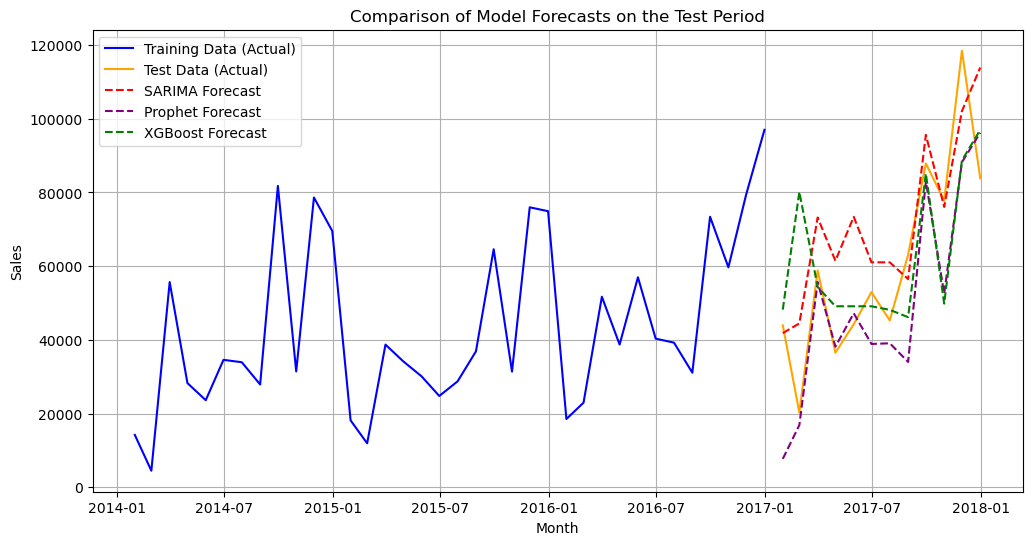


Feature Importance for XGBoost:
                 Feature  Importance
8           Sales_Lag_12    0.752298
9    Sales_RollingMean_3    0.177759
3             month_year    0.032291
0                  month    0.010416
7            Sales_Lag_6    0.009182
5            Sales_Lag_2    0.007576
10   Sales_RollingMean_6    0.004324
11  Sales_RollingMean_12    0.002603
6            Sales_Lag_3    0.002446
2                   year    0.000860
4            Sales_Lag_1    0.000245
1                quarter    0.000000


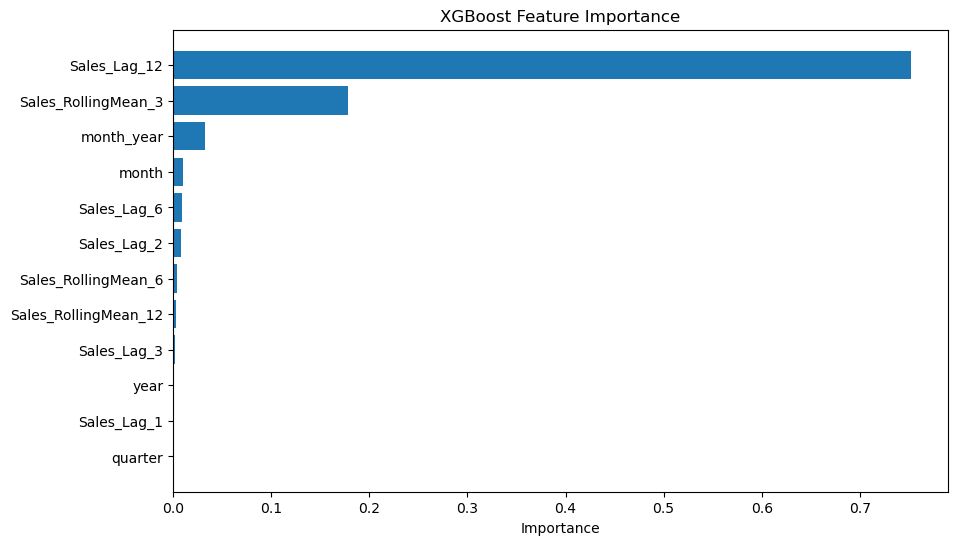

In [8]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import mean_squared_error, mean_absolute_error
import statsmodels.api as sm
from statsmodels.tsa.seasonal import seasonal_decompose
from pmdarima import auto_arima # For automatic SARIMA parameter selection
from prophet import Prophet
import xgboost as xgb

# --- 0. Evaluation Metrics ---
# Helper functions for calculating metrics
def calculate_metrics(y_true, y_pred):
    rmse = np.sqrt(mean_squared_error(y_true, y_pred))
    mae = mean_absolute_error(y_true, y_pred)

    # MAPE calculation, handle potential division by zero
    y_true, y_pred = np.array(y_true), np.array(y_pred)
    # Add a small epsilon to avoid division by zero if y_true contains zeros
    mape = np.mean(np.abs((y_true - y_pred) / (y_true + 1e-8))) * 100
    # Set MAPE to NaN if the original y_true was all zeros (where MAPE is undefined)
    mape = mape if np.isfinite(mape) else np.nan

    # SMAPE calculation
    # Add a small epsilon to avoid division by zero if both y_true and y_pred are zeros
    smape = np.mean(2 * np.abs(y_pred - y_true) / (np.abs(y_true) + np.abs(y_pred) + 1e-8)) * 100
    # Set SMAPE to 0 if both y_true and y_pred were all zeros
    smape = smape if np.isfinite(smape) else 0

    return {'RMSE': rmse, 'MAE': mae, 'MAPE': mape, 'SMAPE': smape}

# --- 1. Data Loading and Preprocessing ---
file_path = 'C:/Users/Olga/Desktop/save in one/Sample - Superstore.csv' # Specify the correct file path
df = pd.read_csv(file_path, encoding='latin1') # or 'utf-8' if latin1 is not suitable

# Converting Order Date to datetime
df['Order Date'] = pd.to_datetime(df['Order Date'])

# Aggregating by month, summing sales
# Using Order Date as the time index
monthly_sales = df.groupby(pd.Grouper(key='Order Date', freq='M'))['Sales'].sum().reset_index()

# Renaming columns
monthly_sales = monthly_sales.rename(columns={'Order Date': 'Month', 'Sales': 'Total_Sales'})

# Ensure the time series is continuous and sorted
monthly_sales = monthly_sales.set_index('Month')
# Fill missing months with zeros
monthly_sales = monthly_sales.asfreq('M', fill_value=0)
monthly_sales = monthly_sales.sort_index()

print("First 5 rows of aggregated data:")
print(monthly_sales.head())
print("\nLast 5 rows of aggregated data:")
print(monthly_sales.tail())
print(f"\nTotal {len(monthly_sales)} months of data (from {monthly_sales.index.min().strftime('%Y-%m-%d')} to {monthly_sales.index.max().strftime('%Y-%m-%d')})")

# --- 2. Splitting Data into Training and Test Sets ---
# Use data up to a certain date for training, the rest for testing
# For example, use data up to the end of 2016 for training, test on 2017 and 2018
train_end_date = '2016-12-31'

train_data = monthly_sales[monthly_sales.index <= train_end_date]
test_data = monthly_sales[monthly_sales.index > train_end_date]

print(f"\nTraining set size: {len(train_data)} months (up to {train_end_date})")
print(f"Test set size: {len(test_data)} months ({test_data.index.min().strftime('%Y-%m-%d')} - {test_data.index.max().strftime('%Y-%m-%d')})")

# Actual values for the test period for evaluation
y_test_actual = test_data['Total_Sales']

# Visualization of the split
plt.figure(figsize=(12, 6))
plt.plot(train_data.index, train_data['Total_Sales'], label='Training Data')
plt.plot(test_data.index, test_data['Total_Sales'], label='Test Data (Actual)', color='orange')
plt.title('Data Splitting into Training and Test Sets')
plt.xlabel('Month')
plt.ylabel('Sales')
plt.legend()
plt.grid(True)
plt.show()

# --- 3. Model 1: SARIMA ---
print("\n--- SARIMA Training and Evaluation ---")

# Automatic SARIMA parameter selection
# seasonality=True, m=12 (12 months per year)
# d=1, D=1 - often good starting points requiring one non-seasonal and one seasonal differencing
# error_action='ignore' and suppress_warnings=True help avoid issues with unstable models
sarima_model_fit = auto_arima(train_data['Total_Sales'],
                              start_p=0, start_q=0,
                              max_p=5, max_q=5,
                              m=12,             # Seasonality 12 months
                              start_P=0, start_Q=0,
                              max_P=3, max_Q=3,
                              seasonal=True,    # Include seasonality
                              d=1, D=1,         # Non-seasonal and seasonal differencing
                              trace=True,       # Show selection process
                              error_action='ignore',
                              suppress_warnings=True,
                              stepwise=True)    # Use stepwise approach (faster)

print(f"Found SARIMA parameters: {sarima_model_fit.order} x {sarima_model_fit.seasonal_order}")

# Make forecast on the test period
sarima_forecast = sarima_model_fit.predict(n_periods=len(test_data))
sarima_forecast = pd.Series(sarima_forecast, index=test_data.index) # Assign the correct index

# Evaluation
sarima_metrics = calculate_metrics(y_test_actual, sarima_forecast)
print("SARIMA metrics on the test set:", sarima_metrics)

# --- 4. Model 2: Prophet ---
print("\n--- Prophet Training and Evaluation ---")

# Prophet requires a DataFrame with columns 'ds' (datetime) and 'y' (value)
prophet_train_df = train_data.reset_index().rename(columns={'Month': 'ds', 'Total_Sales': 'y'})

# Prophet model initialization
# Parameters can be added to tune seasonality, trend, etc.
prophet_model = Prophet(
    yearly_seasonality=True, # Explicit yearly seasonality
    # weekly_seasonality=False, # If data is monthly, weekly seasonality is not relevant
    # daily_seasonality=False # If data is monthly, daily seasonality is not relevant
    seasonality_mode='multiplicative' # or 'additive' - multiplicative is often better for sales
)

# External regressors or holidays can be added here if available
# prophet_model.add_country_holidays(country_name='US') # If US holidays are relevant

# Training the model
prophet_model.fit(prophet_train_df)

# Creating a future DataFrame for forecasting
future = prophet_model.make_future_dataframe(periods=len(test_data), freq='M')

# Forecasting
prophet_forecast_df = prophet_model.predict(future)

# Select only forecasts for the test period
prophet_forecast = prophet_forecast_df.set_index('ds')['yhat']
prophet_forecast = prophet_forecast[prophet_forecast.index.isin(test_data.index)]

# Ensure predictions are non-negative
prophet_forecast[prophet_forecast < 0] = 0

# Evaluation
prophet_metrics = calculate_metrics(y_test_actual, prophet_forecast)
print("Prophet metrics on the test set:", prophet_metrics)


# --- 5. Model 3: XGBoost ---
print("\n--- XGBoost Training and Evaluation ---")

# Function for creating features for XGBoost (used ONLY for creating the TRAINING set)
def create_xgb_features_for_train(df_agg):
    df_agg = df_agg.copy()
    df_agg['month'] = df_agg.index.month
    df_agg['quarter'] = df_agg.index.quarter
    df_agg['year'] = df_agg.index.year
    df_agg['month_year'] = df_agg.index.year * 100 + df_agg.index.month # Combined year and month feature

    # Lagged features
    for lag in [1, 2, 3, 6, 12]:
        df_agg[f'Sales_Lag_{lag}'] = df_agg['Total_Sales'].shift(lag)

    # Rolling means (use shift(1) to exclude the current value)
    for window in [3, 6, 12]:
         # Need closed='left' to exclude the current period's sales when calculating rolling stats
         df_agg[f'Sales_RollingMean_{window}'] = df_agg['Total_Sales'].shift(1).rolling(window=window, closed='left').mean()
         # Rolling standard deviations etc. can be added

    # Drop rows with NaN due to lags and windows at the start of the series
    return df_agg.dropna()


# Apply feature generation to training data for model training
xgb_train_df = create_xgb_features_for_train(train_data)

# Define features (X) and target variable (y) for training
xgb_features = [col for col in xgb_train_df.columns if col not in ['Total_Sales']]
xgb_target = 'Total_Sales'

X_train_xgb = xgb_train_df[xgb_features]
y_train_xgb = xgb_train_df[xgb_target]

print(f"XGBoost uses {len(xgb_features)} features.")
print("Example features:", xgb_features[:5], "...")
print(f"XGBoost training set contains data from {xgb_train_df.index.min().strftime('%Y-%m-%d')} to {xgb_train_df.index.max().strftime('%Y-%m-%d')}")


# Initialize and train the XGBoost regressor
xgb_model = xgb.XGBRegressor(objective='reg:squarederror',
                             n_estimators=500,
                             learning_rate=0.05,
                             max_depth=6,
                             random_state=42,
                             n_jobs=-1)

xgb_model.fit(X_train_xgb, y_train_xgb)

# --- Recursive Forecasting for XGBoost ---
print("\nStarting recursive XGBoost forecast...")

xgb_forecast_list = []
# Start with historical sales data from the training set.
# We will append forecasted values to this history iteratively.
sales_history = train_data['Total_Sales'].copy()

# Determine the minimum number of historical points required to calculate all features
# (maximum lag or window size)
lags_to_use = [1, 2, 3, 6, 12]
windows_to_use = [3, 6, 12]
min_history_needed = max(lags_to_use + windows_to_use) if (lags_to_use or windows_to_use) else 0


# Ensure sales_history has enough data to calculate features for the first forecast step
if len(sales_history) < min_history_needed:
     print(f"WARNING: Sales history ({len(sales_history)} months) might be insufficient to calculate all features ({min_history_needed} months required). The forecast might be inaccurate for the initial periods.")
     # You might need to add some initial data from the test set or reduce lags/windows
     # For this example, we proceed but results for early periods might be based on NaNs or limited history.

for i in range(len(test_data)):
    # Current forecast date (the i-th date in the test set)
    current_forecast_date = test_data.index[i]

    # Create a dictionary for the current date's features
    current_features = {}

    # --- Manual feature calculation for the current date ---
    # Time features (these are known for any future date)
    current_features['month'] = current_forecast_date.month
    current_features['quarter'] = current_forecast_date.quarter
    current_features['year'] = current_forecast_date.year
    current_features['month_year'] = current_forecast_date.year * 100 + current_forecast_date.month

    # Lagged features - take from sales_history
    # Must match those used during training (lags_to_use)
    for lag in lags_to_use:
         lag_date = current_forecast_date - pd.DateOffset(months=lag)
         if lag_date in sales_history.index:
             current_features[f'Sales_Lag_{lag}'] = sales_history.loc[lag_date]
         else:
             # If the lag date is outside the available history, the feature value will be NaN
             # XGBoost can handle NaN, or you can fill with 0, mean, etc.
             current_features[f'Sales_Lag_{lag}'] = np.nan

    # Rolling means - calculate from sales_history
    # Must match those used during training (windows_to_use)
    for window in windows_to_use:
        # Need values from (date - window size) up to (date - 1 period)
        start_rolling_date = current_forecast_date - pd.DateOffset(months=window)
        end_rolling_date = current_forecast_date - pd.DateOffset(months=1)

        # Select historical values for this window from sales_history
        # .loc[] with a date slice includes both boundaries
        # Need to handle cases where start_rolling_date is before the start of sales_history
        if start_rolling_date < sales_history.index.min():
             rolling_window_data = sales_history.loc[sales_history.index.min() : end_rolling_date]
        else:
             rolling_window_data = sales_history.loc[start_rolling_date : end_rolling_date]

        # Calculate mean only if the window contains data up to end_rolling_date
        # (Ensuring the window is not empty and extends sufficiently back)
        # Check if end_rolling_date is actually in the index, and if there's data in the slice
        if end_rolling_date in sales_history.index and not rolling_window_data.empty:
            current_features[f'Sales_RollingMean_{window}'] = rolling_window_data.mean()
        else:
             # If the window cannot be fully formed or is empty, use NaN or a default value
             current_features[f'Sales_RollingMean_{window}'] = np.nan # Or another default value like 0


    # --- Forming DataFrame for prediction ---
    # Convert feature dictionary to a DataFrame for prediction (one row)
    # Important: column order must match xgb_features used during training
    X_current_forecast = pd.DataFrame([current_features], index=[current_forecast_date])

    # Ensure column order matches the one the model was trained on. This is critical!
    # Any features in xgb_features but not in current_features will be added as NaN
    # Any features in current_features but not in xgb_features will be dropped
    X_current_forecast = X_current_forecast.reindex(columns=xgb_features)


    # --- Make forecast for the current date ---
    # XGBoost can handle NaNs in prediction, but it's based on how it learned from NaNs (if any)
    # or its internal handling. Filling NaNs here might be necessary depending on the scenario.
    # For this example, we rely on XGBoost's default NaN handling.
    current_prediction = xgb_model.predict(X_current_forecast)[0]

    # Ensure forecast is non-negative (for sales)
    current_prediction = max(0, current_prediction)

    # Add forecast to the list
    xgb_forecast_list.append(current_prediction)

    # --- Update sales history for the next iteration ---
    # Add the forecasted value to our sales history (sales_history)
    # so it can be used to calculate lags/rolling features for subsequent forecasts
    sales_history.loc[current_forecast_date] = current_prediction

# Convert the list of forecasts to a Series with the correct test set index
xgb_forecast = pd.Series(xgb_forecast_list, index=test_data.index)

# Evaluation
xgb_metrics = calculate_metrics(y_test_actual, xgb_forecast)
print("XGBoost metrics on the test set:", xgb_metrics)


# --- 6. Comparing Results ---
print("\n--- Forecast Metrics Comparison ---")

results = pd.DataFrame({
    'SARIMA': sarima_metrics,
    'Prophet': prophet_metrics,
    'XGBoost': xgb_metrics
}).T # Transpose for easier reading

print(results)

# Visualize all forecasts on the test period
plt.figure(figsize=(12, 6))
plt.plot(train_data.index, train_data['Total_Sales'], label='Training Data (Actual)', color='blue')
plt.plot(test_data.index, y_test_actual, label='Test Data (Actual)', color='orange')
plt.plot(test_data.index, sarima_forecast, label='SARIMA Forecast', color='red', linestyle='--')
plt.plot(test_data.index, prophet_forecast, label='Prophet Forecast', color='purple', linestyle='--')
plt.plot(test_data.index, xgb_forecast, label='XGBoost Forecast', color='green', linestyle='--')

plt.title('Comparison of Model Forecasts on the Test Period')
plt.xlabel('Month')
plt.ylabel('Sales')
plt.legend()
plt.grid(True)
plt.show()

# Visualization of Feature Importance for XGBoost
print("\nFeature Importance for XGBoost:")
# Re-calculate importance using the model trained on xgb_train_df which has correct features
importance = xgb_model.feature_importances_
feature_importance = pd.DataFrame({'Feature': xgb_features, 'Importance': importance}).sort_values(by='Importance', ascending=False)
print(feature_importance)

plt.figure(figsize=(10, 6))
plt.barh(feature_importance['Feature'], feature_importance['Importance'])
plt.title('XGBoost Feature Importance')
plt.xlabel('Importance')
plt.gca().invert_yaxis() # Most important features at the top
plt.show()